# Курсовая работа № 2
## Аналитика. Начальный уровень

Курсовая работа состоит из двух частей – обязательной и дополнительной. **Для зачета необходимо выполнение только первой части.** Выполнение второй части может потребовать дополнительные знания Python.

- [Часть первая](#Часть-первая)
- [Часть вторая](#Часть-вторая)

## Часть первая


Перед вами стоит задача – подготовить аналитический отчет для HR-отдела. На основании проведенной аналитики предполагается составить рекомендации для отдела кадров по стратегии набора персонала, а также по взаимодействию с уже имеющимися сотрудниками.
<br><br> В базе данных лежит набор таблиц, которые содержат данные о сотрудниках вымышленной компании.
Сделайте обзор штата сотрудников компании. Составьте набор предметов исследования, а затем проверьте их на данных. Вся аналитика должна быть выполена с помощью SQL. Впоследствии данные можно визуализировать, однако финальные датафреймы для графиков также должны быть подготовлены с помощью SQL. <br><br>

Примеры гипотез:
1. Есть зависимость между `perfomance score` и тем, под чьим руководством работает сотрудник.
2. Есть зависимость между продолжительностью работы в компании и семейным положением сотрудника.
2. Есть зависимость между продолжительностью работы в компании и возрастом сотрудника.

<br><br>
Параметры для подключения следующие: хост – `dsstudents.skillbox.ru`, порт – `5432`, имя базы данных – `human_resources`, пользователь – `readonly`, пароль – `6hajV34RTQfmxhS`. Таблицы, доступные для анализа, – `hr_dataset`, `production_staff`, `recruiting_costs`, `salary_grid`.

## 0. Подготовка данных

In [1]:
import psycopg2
import pandas as pd

In [2]:
tables = {'hr_dataset':None, 
          'production_staff':None,
          'recruiting_costs':None,
          'salary_grid':None}

In [3]:
pg_connection = {
    "host": "dsstudents.skillbox.ru",
    "port": 5432,
    "dbname": "human_resources",
    "user": "readonly",
    "password": "6hajV34RTQfmxhS"
}

conn = psycopg2.connect(**pg_connection)

In [4]:
def info(table, conn):
    sql_str = f'''SELECT * FROM {table} LIMIT 3;'''
    df = pd.read_sql_query(sql_str, conn)
    return df

In [5]:
for table in tables:
    tables[table] = info(table, conn)
#   tables[table].to_excel(f'Data_1/{table}_info.xlsx') Загрузил данные в Excel для подробного рассмотрения

Смотрим на таблицы, чтобы иметь представление о содержимом. Также все таблицы были заранее выгружены в Excel для подробного рассмотрения.

In [6]:
tables['hr_dataset']

,id,Employee Name,Employee Number,marriedid,maritalstatusid,genderid,empstatus_id,deptid,perf_scoreid,age,...,Date of Hire,Days Employed,Date of Termination,Reason For Term,Employment Status,department,position,Manager Name,Employee Source,Performance Score
0,1,"Brown, Mia",1103024456,1,1,0,1,1,3,30,...,2008-10-27,3317,None,N/A - still employed,Active,Admin Offices,Accountant I,Brandon R. LeBlanc,Diversity Job Fair,Fully Meets
1,2,"LaRotonda, William",1106026572,0,2,1,1,1,3,34,...,2014-01-06,1420,None,N/A - still employed,Active,Admin Offices,Accountant I,Brandon R. LeBlanc,Website Banner Ads,Fully Meets
2,3,"Steans, Tyrone",1302053333,0,0,1,1,1,3,31,...,2014-09-29,1154,None,N/A - still employed,Active,Admin Offices,Accountant I,Brandon R. LeBlanc,Internet Search,Fully Meets


In [7]:
tables['production_staff']

,id,Employee Name,Race Desc,Date of Hire,TermDate,Reason for Term,Employment Status,Department,Position,Pay,Manager Name,Performance Score,Abutments/Hour Wk 1,Abutments/Hour Wk 2,Daily Error Rate,90-day Complaints
0,1,"Albert, Michael",White,2011-08-01,None,N/A - still employed,Active,Production,Production Manager,$54.50,Elisa Bramante,Fully Meets,0,0,0,0
1,2,"Bozzi, Charles",Asian,2013-09-30,2014-08-07,retiring,Voluntarily Terminated,Production,Production Manager,$50.50,Elisa Bramante,Fully Meets,0,0,0,0
2,3,"Butler, Webster L",White,2016-01-28,None,N/A - still employed,Active,Production,Production Manager,$55.00,Elisa Bramante,Exceeds,0,0,0,0


In [8]:
tables['recruiting_costs']

,id,Employment Source,January,February,March,April,May,June,July,August,September,October,November,December,Total
0,1,Billboard,520,520,520,520,0,0,612,612,729,749,910,500,6192
1,2,Careerbuilder,410,410,410,820,820,410,410,820,820,1230,820,410,7790
2,3,Company Intranet - Partner,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
tables['salary_grid']

,id,Position,Salary Min,Salary Mid,Salary Max,Hourly Min,Hourly Mid,Hourly Max
0,1,Administrative Assistant,30000,40000,50000,14.42,19.23,24.04
1,2,Sr. Administrative Assistant,35000,45000,55000,16.83,21.63,26.44
2,3,Accountant I,42274,51425,62299,20.32,24.72,29.95


## 1. Гипотезы и вычисления

### 1.1 Есть зависимость производительности от:

* брачного статуса;
* региона проживания;
* количества отработанных лет;
* руководителя;
* наёмной компании.

Для начала построим таблицу соответствий perf_scoreid и Performance Score

In [10]:
sql_str = '''SELECT DISTINCT perf_scoreid, "Performance Score" FROM  hr_dataset ORDER BY 1;'''
perf_score = pd.read_sql_query(sql_str, conn)

In [11]:
perf_score

,perf_scoreid,Performance Score
0,0,90-day meets
1,1,PIP
2,2,Needs Improvement
3,3,Fully Meets
4,4,Exceeds
5,5,Exceptional
6,9,N/A- too early to review


Теперь мы знаем, какие значения могут быть в Производительности. Вариант 9 в дальнейшем будем отбрасывать, как данные без достаточного кол-ва информации, 0-евое отбросим, так как относится только к тем, кто только закончил испытательный срок. 
1 и 2 - с низкой производительностью, а 3, 4 и 5 - с соответственно хорошей, отличной и исключительной успеваемостью.

Далее, строим таблицу соответствий для брачного статуса (id и значений).

In [64]:
sql_str = '''SELECT DISTINCT maritalstatusid, maritaldesc FROM  hr_dataset ORDER BY 1;'''
marital = pd.read_sql_query(sql_str, conn)

In [66]:
marital

,maritalstatusid,maritaldesc
0,0,Single
1,1,Married
2,2,Divorced
3,3,Separated
4,4,Widowed


Получим список всех регионов:

In [14]:
sql_str = '''SELECT DISTINCT state FROM  hr_dataset ORDER BY state;'''
states = pd.read_sql_query(sql_str, conn)

In [15]:
states.head()

,state
0,AL
1,AZ
2,CA
3,CO
4,CT


Всех руководителей:

In [16]:
sql_str = '''SELECT DISTINCT "Manager Name" FROM  hr_dataset ORDER BY 1;'''
managers = pd.read_sql_query(sql_str, conn)

In [17]:
managers.head()

,Manager Name
0,Alex Sweetwater
1,Amy Dunn
2,Board of Directors
3,Brandon R. LeBlanc
4,Brannon Miller


Все наёмные компании:

In [18]:
sql_str = '''SELECT "Employment Source" FROM recruiting_costs ORDER BY 1;'''
comps = pd.read_sql_query(sql_str, conn)

In [19]:
comps

,Employment Source
0,Billboard
1,Careerbuilder
2,Company Intranet - Partner
3,Diversity Job Fair
4,Employee Referral
5,Glassdoor
6,Information Session
7,Internet Search
8,MBTA ads
9,Monster.com


Попробуем построить корреляцию по формуле Спирмена для всех признаков. Количество отработанных дней переведём в качественный признак разбиением на интервалы (1 год = 1 интервал).

In [20]:
sql_str = '''SELECT perf_scoreid, maritalstatusid, "Days Employed" as days_employed,"Days Employed"/365  as years_employed, state, "Manager Name" as manager_name,
"Employee Source" as employee_source
FROM hr_dataset
WHERE (perf_scoreid < 9)
ORDER BY 1;'''
main_df = pd.read_sql_query(sql_str, conn)

In [21]:
main_df.head()

,perf_scoreid,maritalstatusid,days_employed,years_employed,state,manager_name,employee_source
0,0,0,2211,6,MA,Kissy Sullivan,Newspager/Magazine
1,0,0,309,0,MA,Simon Roup,Vendor Referral
2,0,1,1056,2,MA,Simon Roup,Glassdoor
3,0,1,1908,5,MA,Elijiah Gray,Monster.com
4,0,0,2148,5,MA,Alex Sweetwater,Monster.com


In [22]:
from scipy.stats import spearmanr as qual_corr

In [23]:
for col in main_df.columns[1:]:
    print(f"\nCorrelation with {col}:\t{qual_corr(main_df.perf_scoreid, main_df[col]).correlation}")


Correlation with maritalstatusid:	0.00903570795588563

Correlation with days_employed:	0.18835498785836924

Correlation with years_employed:	0.1952250940605742

Correlation with state:	0.009294728310753227

Correlation with manager_name:	-0.12103581493531973

Correlation with employee_source:	-0.09220636878364805


C:\Games\lib\site-packages\scipy\stats\stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


На данном этапе мы выяснили приоритетность признаков, которые больше всего имеют влияние на производительность. В первую очередь, это количество отработанных лет (что логично), руководитель и HR-компания. Остальные характеристики уже можно не рассматривать.

### 1.1.1 Зависимость от количества отработанных дней

Теперь попробуем построить диаграмму рассеивания для зависимости производительности от количества отработанных дней.

In [24]:
from matplotlib import pyplot as plt

In [25]:
%matplotlib inline

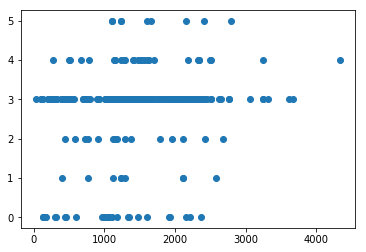

In [26]:
plt.scatter(main_df.days_employed, main_df.perf_scoreid)

Диаграмма мало что даёт: мы знаем, что большинство сотрудников преуспевают и что преодолев порог в 2500-2600 рабочих дней, сотрудник точно преуспевает, хотя таких мало. Посмотрим на соотношение производительности в процентах.

In [27]:
sql_str = '''SELECT perf_scoreid, COUNT(*) FROM hr_dataset WHERE perf_scoreid < 9 GROUP BY 1 ORDER BY 1;'''
ps_relations = pd.read_sql_query(sql_str, conn)

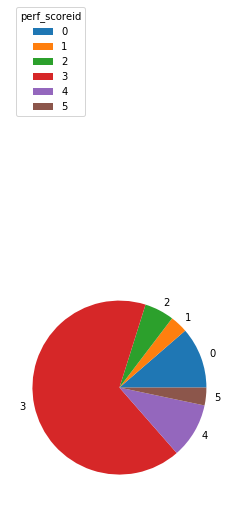

In [28]:
fig, subplot = plt.subplots()

wedges, texts = subplot.pie(ps_relations['count'], explode = None, labels = ps_relations.perf_scoreid)

subplot.legend(wedges, ps_relations.perf_scoreid,
               title = "perf_scoreid",
               loc = "center left",
               bbox_to_anchor = {1.5, 0, 0.5, 1})

In [29]:
ps_relations

,perf_scoreid,count
0,0,31
1,1,9
2,2,15
3,3,181
4,4,28
5,5,9


Теперь отразим эти данные на годовой динамике.

In [30]:
sql_str = '''SELECT perf_scoreid,"Days Employed"/365  as years_employed,
COUNT(*)
FROM hr_dataset
WHERE perf_scoreid < 9
GROUP BY 1,2
ORDER BY 1,2;'''
ps_years = pd.read_sql_query(sql_str, conn)

In [31]:
sql_str = '''SELECT "Days Employed"/365  as years_employed, COUNT(*)
FROM hr_dataset
WHERE perf_scoreid < 9
GROUP BY 1
ORDER BY 1;'''
years_count = pd.read_sql_query(sql_str, conn)

In [32]:
years_count.columns = ('years_employed', 'ppl')

In [33]:
years_count

,years_employed,ppl
0,0,24
1,1,29
2,2,31
3,3,69
4,4,47
5,5,34
6,6,24
7,7,7
8,8,4
9,9,2


In [34]:
ps_years = pd.merge(ps_years, years_count)

In [35]:
ps_years['percent'] = ps_years['count']*100./ps_years['ppl']

In [36]:
ps_years.sort_values(['years_employed', 'perf_scoreid'], inplace = True)

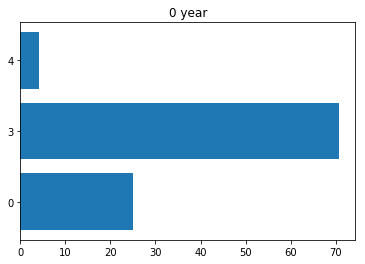

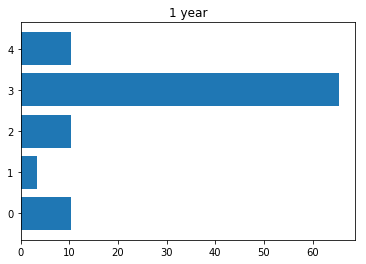

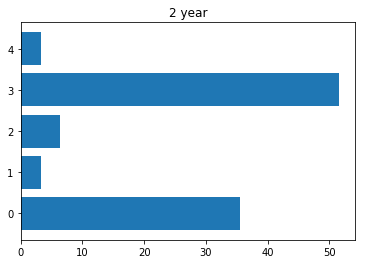

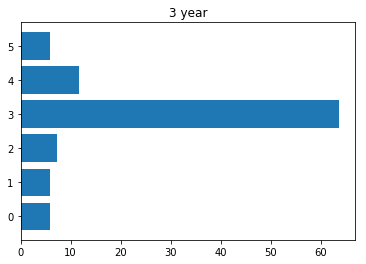

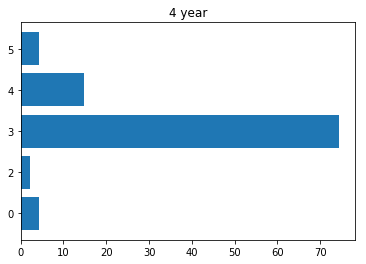

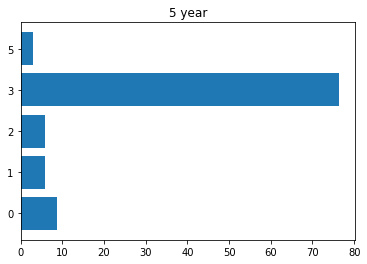

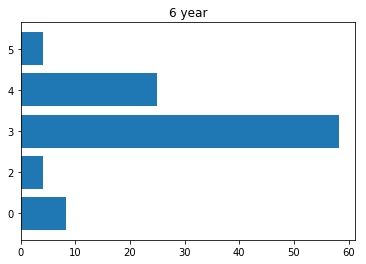

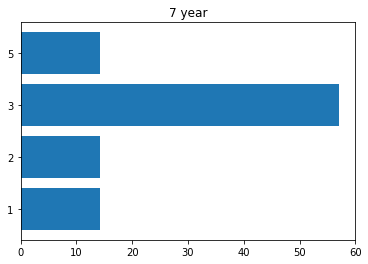

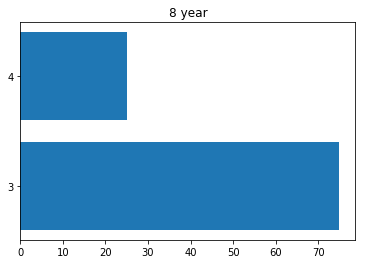

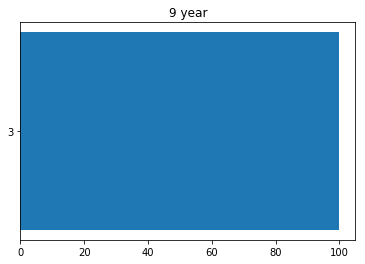

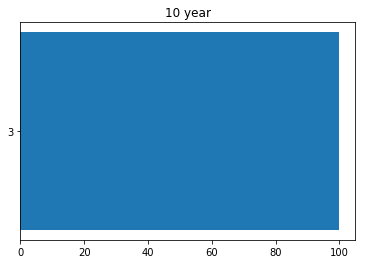

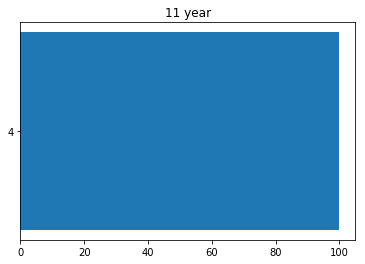

In [37]:
for i in range(12):
    fig, subplot = plt.subplots()
    df = ps_years[ps_years.years_employed == i]
    subplot.barh(list(map(str, df.perf_scoreid)), df.percent)
    subplot.set_title(f"{i} year")
    plt.show()

#### Вывод

Гистограммы сверху сделаны для того, чтобы по годам отследить динамику изменений производительности. Из нее исходит, что на начальном до певого года сотрудники работают усердно. После первого года появляются неуспевающие, части которых приходится вновь проходить 90-дневный испытательный срок, после чего видим пик неуспевающих после 2-х лет работы: много людей вновь проходят испытательный срок (около 36%). После третьего года неуспевающих вместе с испытательным сроком становится меньше (~20%); после 4-го года их меньше 10%, затем их процент поднимается на пару лет и они исчезают, поскольку больше 7 лет работает крайне мало людей и все продуктивно.
Что касается успешных сотрудников, то их уровень поддерживается на более-менее стабильном и высоком уровне. Небольшой спад наблюдается после второго года, но после третьего производительность начинает подниматься, к 6 году достигает более 80% успешных сотрудников, ну а потом сотрудников меньше, а процент производительности колеблется около 70%. 

На динамику производительности относительно отработанного времени очень трудно влиять, потому что эту характеристику произвольно корректировать нельзя. Однако выше установленная динамика помогает понять, на каких этапах работы стоит усилить контроль над сотрудниками или принять поощрительные меры. В данном случае мы выяснили, что после второго года работы больше всего сотрудников претерпевают неудачи, следовательно, именно в этом случае следует обратить внимание на "рейтинг" сотрудников и постараться предотвратить кризис раньше его возникновения (тренинги, отпускные, перераспределение рабочей нагрузки и т.д.).

### 1.1.2 Зависимость от руководителя

Попытаемся теперь посмотреть на производительность рабочих под руководством каждого менеджера.

In [38]:
sql_str = '''SELECT "Manager Name" as manager,perf_scoreid, COUNT(*)
FROM hr_dataset
WHERE perf_scoreid < 9
GROUP BY 1,2
ORDER BY 1,2;'''
ps_manager = pd.read_sql_query(sql_str, conn)

In [39]:
managers.head()

,Manager Name
0,Alex Sweetwater
1,Amy Dunn
2,Board of Directors
3,Brandon R. LeBlanc
4,Brannon Miller


C:\Games\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


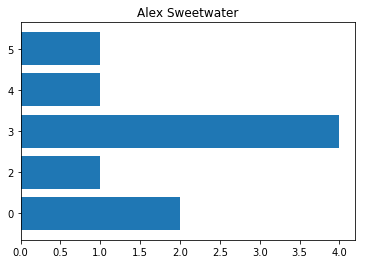

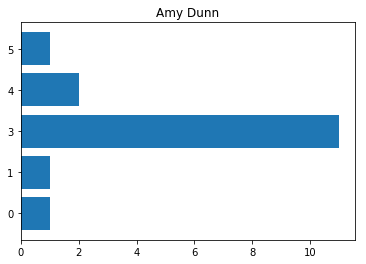

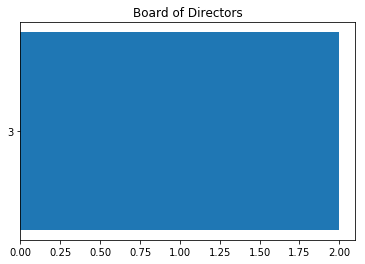

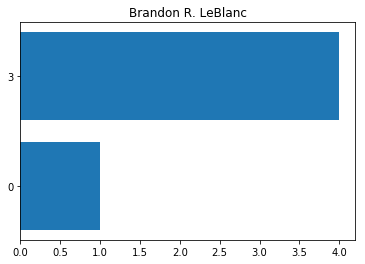

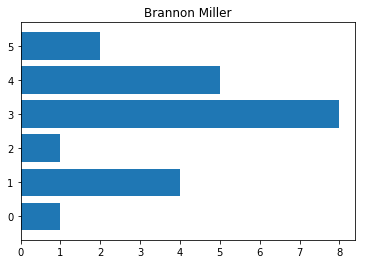

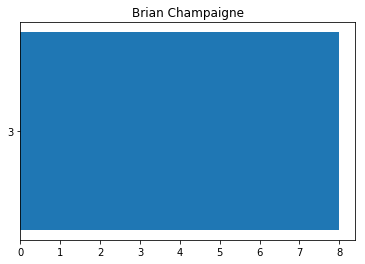

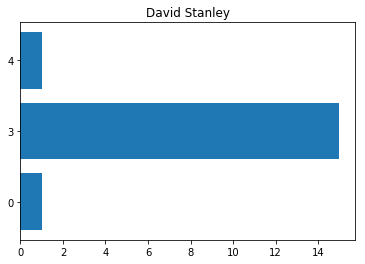

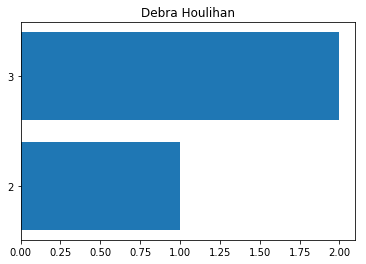

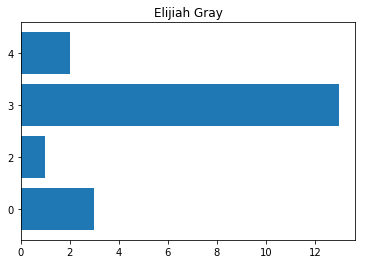

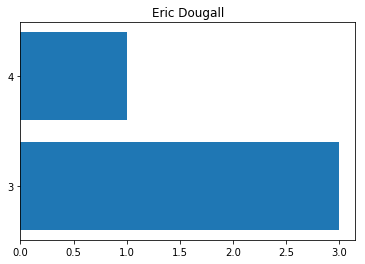

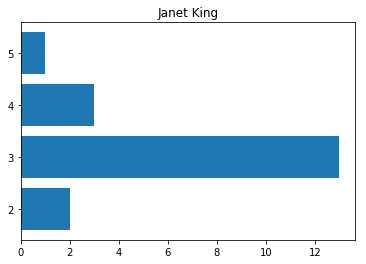

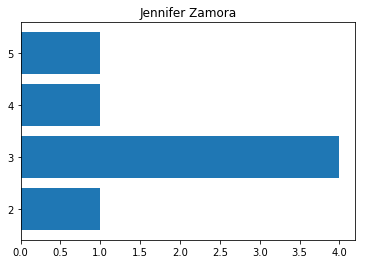

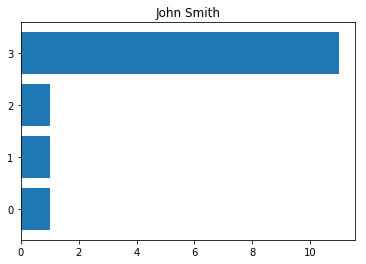

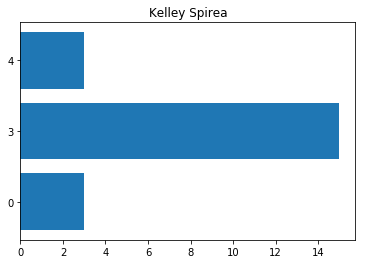

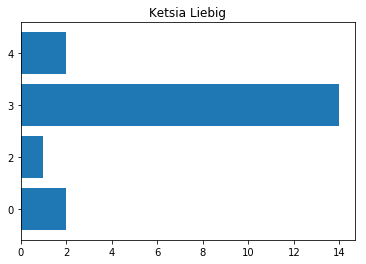

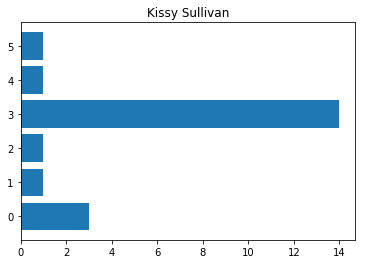

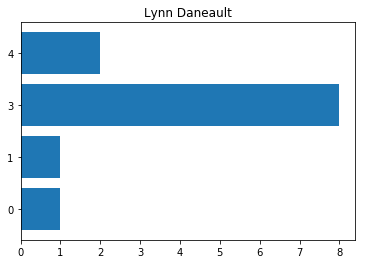

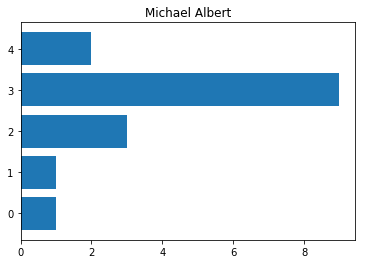

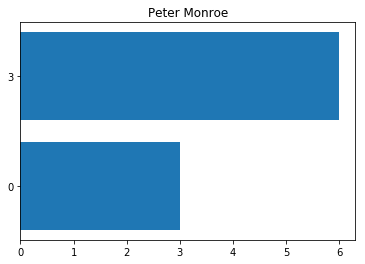

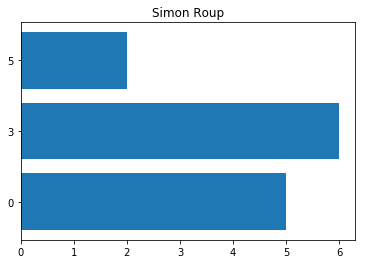

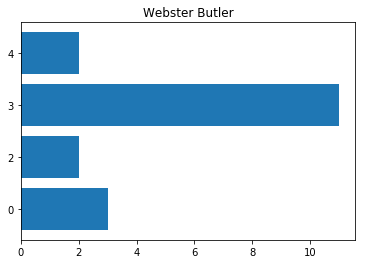

In [40]:
for i in managers["Manager Name"]:
    fig, subplot = plt.subplots()
    df = ps_manager[ps_manager.manager == i]
    subplot.barh(list(map(str, df.perf_scoreid)), df['count'])
    subplot.set_title(f"{i}")
    plt.savefig(f"Managers_Pics/{i}.png")

Выясним, какими отделами и представителями каких должностей руководит каждый менеджер.

In [41]:
sql_str = '''SELECT DISTINCT "Manager Name" as manager, department, position
FROM hr_dataset
WHERE perf_scoreid < 9
ORDER BY 1,2,3;'''
manager_qual = pd.read_sql_query(sql_str, conn)

In [42]:
manager_qual

,manager,department,position
0,Alex Sweetwater,Software Engineering,Software Engineer
1,Amy Dunn,Production,Production Technician I
2,Amy Dunn,Production,Production Technician II
3,Board of Directors,Admin Offices,Sr. Accountant
4,Board of Directors,Executive Office,President & CEO
5,Brandon R. LeBlanc,Admin Offices,Accountant I
6,Brandon R. LeBlanc,Admin Offices,Administrative Assistant
7,Brandon R. LeBlanc,Admin Offices,Sr. Accountant
8,Brannon Miller,Production,Production Technician I
9,Brannon Miller,Production,Production Technician II


In [43]:
sql_str = '''SELECT DISTINCT "Manager Name" as manager, department, position
FROM hr_dataset
WHERE perf_scoreid < 9
ORDER BY 3,2,1;'''
manager_qual2 = pd.read_sql_query(sql_str, conn)

In [44]:
manager_qual2

,manager,department,position
0,Brandon R. LeBlanc,Admin Offices,Accountant I
1,Brandon R. LeBlanc,Admin Offices,Administrative Assistant
2,John Smith,Sales,Area Sales Manager
3,Lynn Daneault,Sales,Area Sales Manager
4,Brian Champaigne,IT/IS,BI Developer
5,Jennifer Zamora,IT/IS,BI Director
6,Janet King,IT/IS,CIO
7,Brian Champaigne,IT/IS,Data Architect
8,Simon Roup,IT/IS,Database Administrator
9,Janet King,Production,Director of Operations


Пройдемся по всем, чтобы оценить эффективность каждого менеджера.
1. Alex Sweetwater - очень хороший рейтинг, лишь один неуспевающий. Просто нужно отправить неуспевающего на PIP.
2. Amy Dunn - рейтинг получше, отлично справляется с таким количеством подопечных.
3. Совет директоров рассматривать не будем, у них 2 человека по норме.
4. Brandon R. LeBlanc справляется нормально.
5. Brian Champaigne	- у него всё нормально, можно к нему отправить некоторых неуспевающих из отдела IT/IS.
6. Debra Houlihan - Справляется, планы по исправлению всё должны сгладить. В случае нагрузки  других менеджеров отдела продаж можно передать ей в руководство некоторы работников.
7. Eric Dougall - менять нечего, справляется хорошо.
8. Janet King - при такой нагрузке справляется  отлично, просто двоих неуспевающих необходимо отправить на PIP.
9. Jennifer Zamora - менять нечего, справляется хорошо.
10. John Smith - отлично справляется с большой нагрузкой, неуспевающего отправляем на PIP.
11. Lynn Daneault - менять нечего, справляется хорошо.
12. Peter Monroe - пока всё нормально, но 33% испытательного срока говорят о том, что стоит усилить меры контроля над неуспевающими.
13. Simon Roup - более 38% подопечных только с испытательного срока. Нужно принимать меры по отношению к менеджеру, если только это не новенькие.
14. Brannon Miller - более 5 неуспевающих, может, стоит перераспределить подопечных.
15. David Stanley - менять нечего, справляется хорошо.
16. Elijiah Gray - менять нечего, справляется хорошо.
17. Kelley Spirea - менять нечего, справляется хорошо.
18. Ketsia Liebig - менять нечего, справляется хорошо.
19. Kissy Sullivan - более 5 неуспевающих, стоит перераспределить подопечных.
20. Michael Albert - более 5 неуспевающих, стоит перераспределить подопечных.
21. Webster Butler - более 5 неуспевающих, стоит перераспределить подопечных.

Перераспределение подопечных у продукт менеджеров (14-21) значит отдать тем, у кого менять нечего. Продакты - большая часть сотрудников. С ними следует проводить эксперименты, чтобы найти лучшую комбинацию 'менеджер - сотрудники'.

### 1.1.3 Зависимость предприятия по найму

Аналогично с предудыщими вариантами корреляции, запрашиваем данные о каждом предприятии и о произодительности сотрудников, нанятых оттуда.

In [45]:
sql_str = '''SELECT "Employee Source" as source, perf_scoreid as score, COUNT(*) as count
FROM hr_dataset
WHERE perf_scoreid < 9
GROUP BY 1,2
ORDER BY 1,2;'''

comp_score = pd.read_sql_query(sql_str, conn)

In [46]:
sql_str = '''SELECT "Employee Source" as source, COUNT(*) as sum
FROM hr_dataset
WHERE perf_scoreid < 9
GROUP BY 1
ORDER BY 1;'''

comp_count = pd.read_sql_query(sql_str, conn)

In [47]:
comp_score = pd.merge(comp_score, comp_count)

In [48]:
comp_score["percent"] = round((comp_score["count"]/comp_score["sum"])*100, 2)

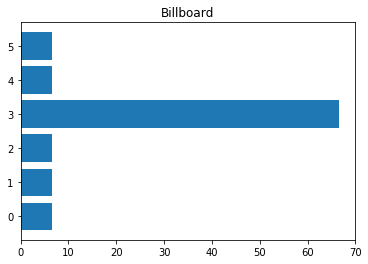

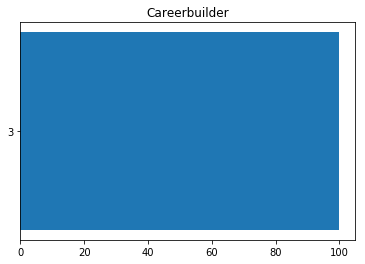

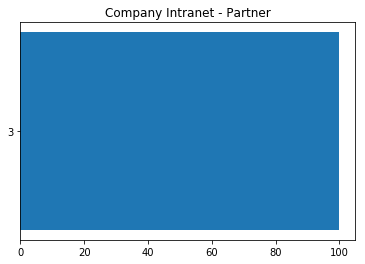

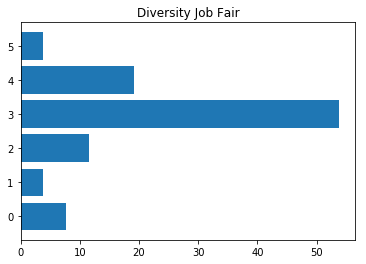

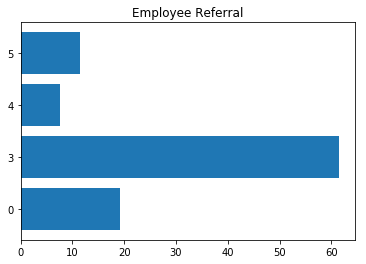

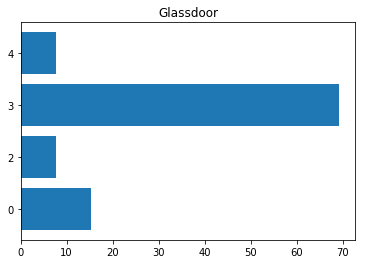

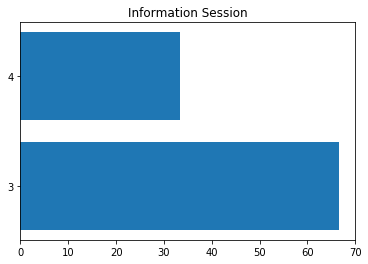

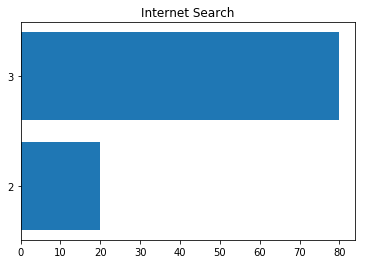

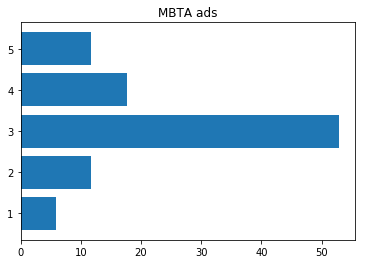

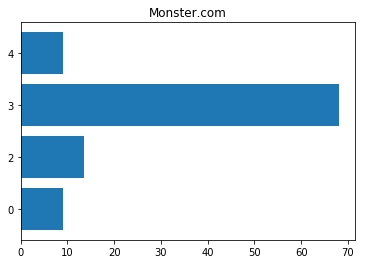

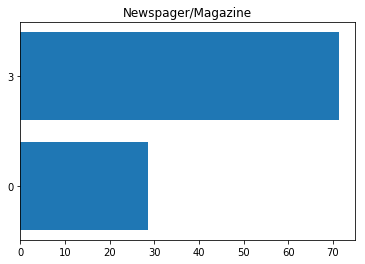

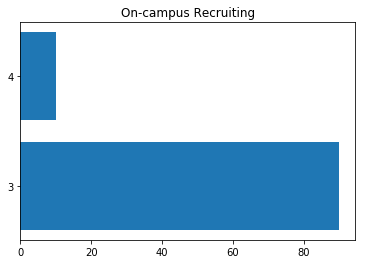

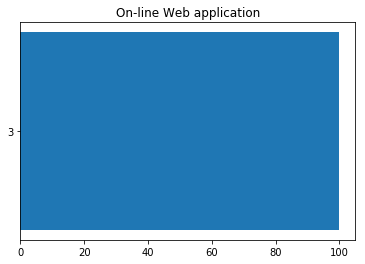

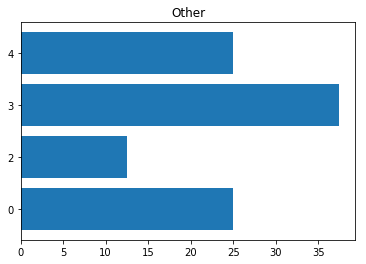

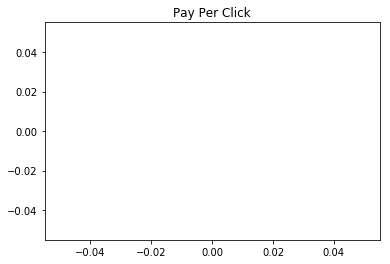

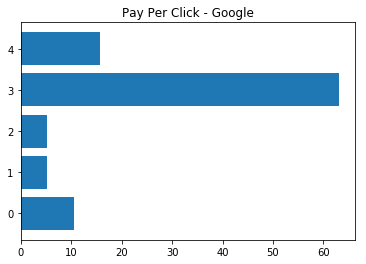

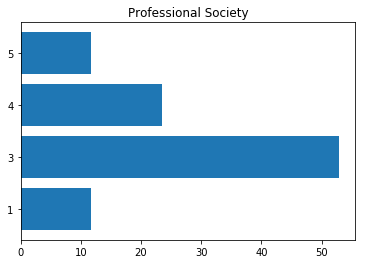

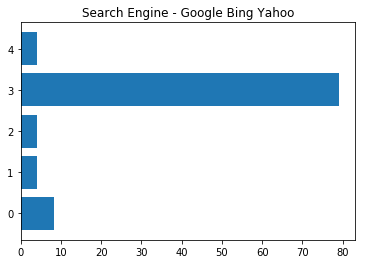

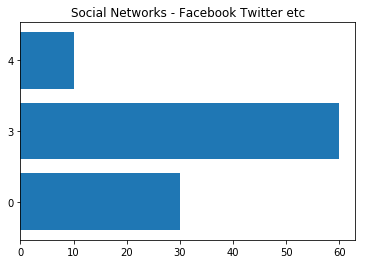

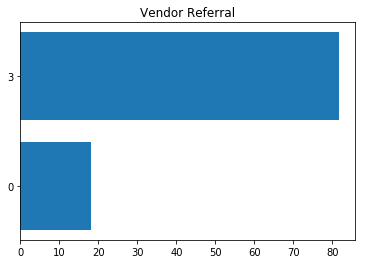

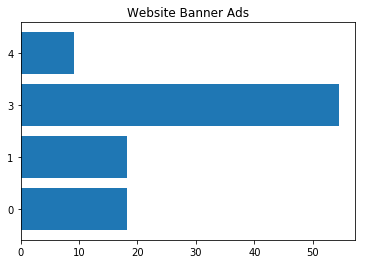

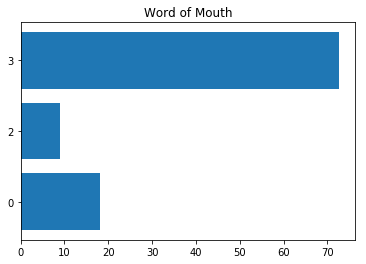

In [49]:
for i in sorted(comps["Employment Source"]):
    fig, subplot = plt.subplots()
    df = comp_score[comp_score.source == i]
    subplot.barh(list(map(str, df.score)), df['percent'])
    subplot.set_title(f"{i}")
    plt.savefig(f"Companies_Pics/{i.replace('/', '_or_')}.png")


In [50]:
set(comp_score[comp_score["sum"] <= 5].source)

{'Careerbuilder',
 'Company Intranet - Partner',
 'Information Session',
 'Internet Search',
 'On-line Web application'}

Источники, выведенные выше, привели слишком мало сотрудников, чтобы их учитывать, а `Pay Per Click` не привёл вообще никого.
Остальные источники распределим по категориям "доверия": если у 100% сотрудников от источника производителььность 3 и выше, то этому источнику мы доверям полностью. Если до 20% сотрудников с источника имеют уровень ниже - то доверяем с малыми ограничениями. Если 20-30% не успевают, то со средним ограничением. Ну а до 40% - доеряем с большими ограничениями.
В первую группу вошёл только один источник - `On-campus Recruiting`;
Во вторую категорию вошли следующие - `Billboard, MBTA ads, Professional Society, Google Bing Yahoo, Vendor Referral `;
В третью - `Diversity Job Fair, Employee Referral, Glassdoor, Monster.com, Pay Per Click – Google, Word of Mouth`;
В четвертую - `Newspager/Magazine, Other, Social Networks - Facebook Twitter etc, Website Banner Ads`.
С бóльшим процентом неуспеваемости источников не встречается.

Рекомендации компания должна установить сама, как они будут относиться к этим источникам и что делать с сотрудниками, прибывшими с определённых источников. Однако, ранжирование рекомендуется проводить именно таким образом, поскольку так учитываются средние характеристики всей компании в целом.

### 1.2 Есть зависимость количества отработанных лет от:

* возраста;
* брачного статуса.

Предварительно отберём нужные данные и выстроим корреляцию.

In [51]:
sql_str = '''SELECT age, maritalstatusid, "Days Employed" as days_employed,"Days Employed"/365  as years_employed
FROM hr_dataset
ORDER BY 1;'''
exp_main_df = pd.read_sql_query(sql_str, conn)

In [52]:
exp_main_df.corr()

,age,maritalstatusid,days_employed,years_employed
age,1.000000,0.060354,0.017666,0.021412
maritalstatusid,0.060354,1.000000,-0.075318,-0.074303
days_employed,0.017666,-0.075318,1.000000,0.990706
years_employed,0.021412,-0.074303,0.990706,1.000000


Матрица корреляций с задачей справляется не сильно хорошо. Посмотрим, как отработает коэффициент Спирмена. Для этого оставим только поля `год работы, брачный статус и возрастной диапазон`. В данном случае, в поле `age` будут записаны значения, кратные семи\*. Это будет значить, что сотрудник, у которого брали возраст, колеблется в диапазоне \[age, age+7).

\* - значение 7 было выбрано экспериментальным путём: оказалось, что при диапазоне с разницей в 7 устанавливается бóльшая корреляция.

In [53]:
sql_str = '''SELECT (age/7)*7 as age, maritalstatusid, "Days Employed"/365  as years_employed
FROM hr_dataset
ORDER BY 1;'''
exp_main_df = pd.read_sql_query(sql_str, conn)

In [54]:
for i in exp_main_df.columns[:-1]:
    print(f"Correlation with {i}:{qual_corr(exp_main_df.years_employed, exp_main_df[i]).correlation}")

Correlation with age:0.061376481481460854
Correlation with maritalstatusid:-0.10361464629072226


Видим, что значения корреляции повысились. Проанализируем характеристики.

### 1.2.1 Зависимость от возраста

In [55]:
sql_str = '''SELECT (age/7)*7 as age, "Days Employed"/365  as years_employed, COUNT(*)
FROM hr_dataset
GROUP BY 1,2
ORDER BY 1;'''
age_year = pd.read_sql_query(sql_str, conn)

In [56]:
sql_str = '''SELECT (age/7)*7 as age, COUNT(*) as sum
FROM hr_dataset
GROUP BY 1
ORDER BY 1;'''
age_count = pd.read_sql_query(sql_str, conn)

In [57]:
age_count

,age,sum
0,21,9
1,28,115
2,35,84
3,42,57
4,49,31
5,56,5
6,63,9


In [58]:
age_year = pd.merge(age_year, age_count)
age_year["percent"] = round((age_year["count"]/age_year["sum"])*100, 2)

In [59]:
ages = tuple(age_year.age.drop_duplicates())

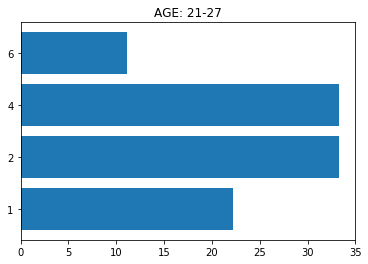

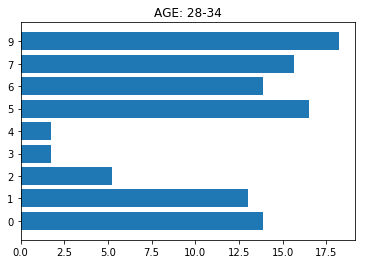

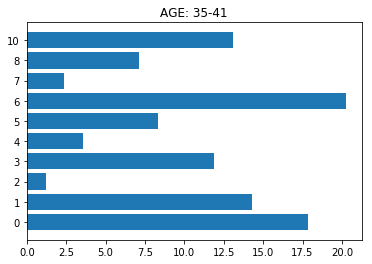

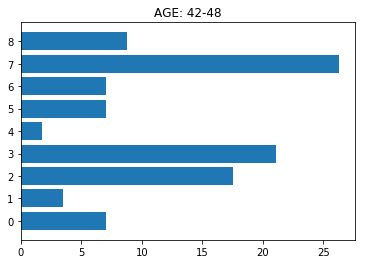

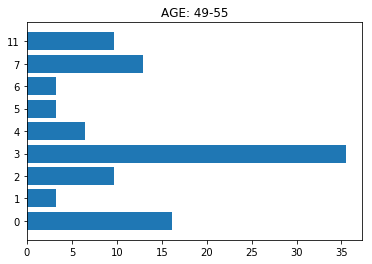

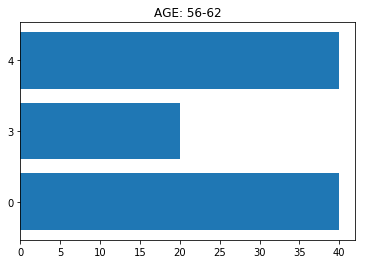

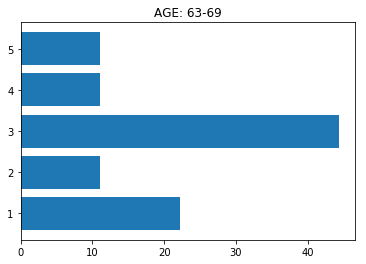

In [60]:
for i in ages:
    fig, subplot = plt.subplots()
    df = age_year[age_year.age == i]
    subplot.barh(list(map(str, sorted(df.years_employed))), df['percent'])
    subplot.set_title(f"AGE: {i}-{i+6}")
    plt.savefig(f"Ages_Pics/{i}.png")

По данным диаграммам можем сказать, что приходят очень многие в компанию примерно до 40 лет. Далее остаются, в основном, "ветераны", но бывают и исключения - мало, но приходят и в 56-65. При этом получается, что основная часть тех самых ветеранов - это те, которые пришли в 21-40. Среди поздних лет (56+) не встречается людей, которые работали больше 5 лет. Получается, что это как раз те редкие случаи, когда люди в таком пожилом возрасте меняют карьеру (ведь таких работников в принципе мало). А те, кто приходит в 40, остаётся ненадолго. 

Получается, что зависимость от возраста очень непростая. Она приобретает значение только если рассматривать его в конкретном диапазоне и только в рамках своего и соседнего диапазона.

Рекомендации  следующие - обратить внимание на стимулирование молодых сотрудников (до 40 лет), потому что дольше всего остаются именно они. Те, кто приходит после 40, нестабильны (наверное, тут можно применить термин `кризис среднего возраста`), поэтому сотрудников в таком возрасте и с малым количеством лет работы в этой компании будет правильнее сократить (если есть необходимость сокращать), за исключением случаев, когда они действительно незаменимы. 

### 1.2.2 Зависимость от брачного статуса

In [81]:
sql_str = '''SELECT maritaldesc, "Days Employed"/365  as years_employed, COUNT(*)
FROM hr_dataset
GROUP BY 1,2
ORDER BY 1,2;'''
marital_year = pd.read_sql_query(sql_str, conn)

In [85]:
sql_str = '''SELECT maritaldesc, COUNT(*) as sum, AVG(age) as meanage
FROM hr_dataset
GROUP BY 1
ORDER BY 1'''
marital_count = pd.read_sql_query(sql_str, conn)

In [83]:
marital_year = pd.merge(marital_year, marital_count)
marital_year["percent"] = round((marital_year["count"]/marital_year["sum"])*100, 2)
marital_year

,maritaldesc,years_employed,count,sum,meanage,percent
0,Divorced,0,9,30,39.000000,30.00
1,Divorced,1,1,30,39.000000,3.33
2,Divorced,2,5,30,39.000000,16.67
3,Divorced,3,5,30,39.000000,16.67
4,Divorced,4,5,30,39.000000,16.67
5,Divorced,6,4,30,39.000000,13.33
6,Divorced,7,1,30,39.000000,3.33
7,Married,0,16,123,38.691057,13.01
8,Married,1,20,123,38.691057,16.26
9,Married,2,20,123,38.691057,16.26


In [87]:
sql_str = '''SELECT maritaldesc, age as meanage
FROM hr_dataset
ORDER BY 1'''
marital_age = pd.read_sql_query(sql_str, conn)

In [94]:
marital_age.groupby("maritaldesc").median() # медианный возраст сотрудников по отделам

,meanage
maritaldesc,
Divorced,35.5
Married,38.0
Separated,43.0
Single,36.0
Widowed,40.5


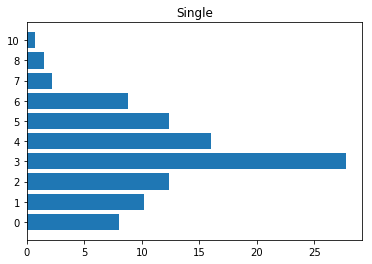

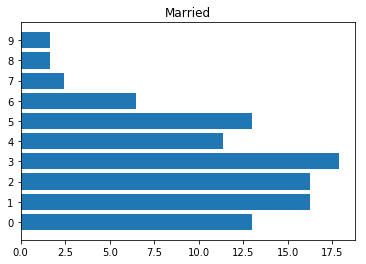

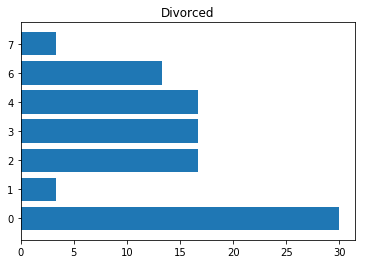

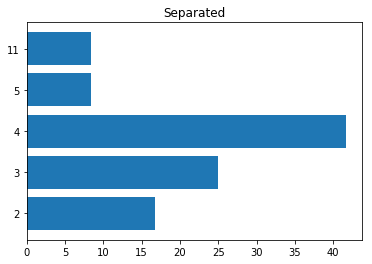

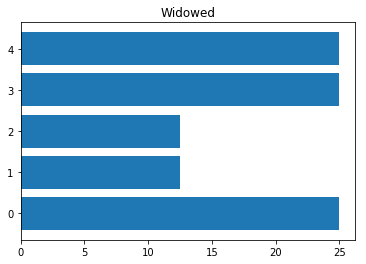

In [80]:
for i in marital.maritaldesc:
    fig, subplot = plt.subplots()
    df = marital_year[marital_year.maritaldesc == i]
    subplot.barh(list(map(str, sorted(df.years_employed))), df['percent'])
    subplot.set_title(f"{i}")
    plt.savefig(f"Marital_Pics/{i}.png")

Диаграмы выше дают нам следующую информацию: большая часть сотрудников хотя бы когда-то была жената, однако на продолжительность работы это влияет немного иначе, чем ожидается. Отрицательный знак корреляции Спирмена говорит о том, что при возрастании id брачного статуса падает продолжительность работы. И это замечается в числе вдовствующих - они, относительно, новички. Стоит предположить, что потеря супруга происходит в довольно позднем возрасте и такие кардинальные перемены в личной жизни влияют на смену карьеры.

Далее, большим процентом долго работающих обладают разведённые, а 11 лет работы среди раздельно живущих - аномалия. Но на наиболее долгую карьеру обеспечены женатые и одинокие, судя по численному превосходству тех, кто отработал 5 или более лет. 

Рекомендация - обращать внимание на одиноких и молодых (до 30 лет) и стараться брать на работу именно этих кандидатов. После них идут женатые и молодые. К тем, кто старше 60 - относится с крайней осторожностью. И если есть выбор между разведённым, отдельно живущим и овдовевшим, то выбор нужно делать в пользу первого.

## Часть вторая

Перед вами стоит задача – подготовить аналитический ответ для SMM-отдела компании Skillbox. <br> Объектом анализа является  [паблик Skillbox Вконтакте](https://vk.com/skillbox_education). <br> <br> 
Подключитесь к  API VK и выгрузите посты со стены паблика Skillbox за интересующий период (определите самостоятельно и обоснуйте). Проанализируйте влияние различных факторов (например, времени публикации) на вовлеченность пользователей (количество лайков, комментариев, голосов в опросах). Сделайте аналитику по рубрикам (примеры рубрик: дизайн-битва, игра по управлению), которые есть в паблике. Выбрать нужные посты можно с помощью регулярных выражений. Составьте перечень рекомандаций для SMM-отдела по итогам анализа. <br> <br> 

Дополнительные инструкции по работе с API VK расположены [здесь](https://nbviewer.jupyter.org/github/vikaborel/dstutorials/blob/master/Дополнительные%20инструкции.ipynb).

In [62]:
### YOUR CODE HERE ###


